In [1]:
!unzip /content/rating_book1.zip

Archive:  /content/rating_book1.zip
  inflating: rating_book1.csv        



Bảng phân tích thống kê:
        Unnamed: 0                 id   rating_count  review_count  \
Count     22500.00           22500.00       22433.00      22433.00   
Min           0.00               1.00           0.00          0.00   
Max       22499.00        56322179.00     7176920.00     173214.00   
Mean      11249.50         9710669.30       39214.46       2046.28   
Median    11249.50         3924038.50        7926.00        491.00   
Q1         5624.75          153791.25        1494.00        109.00   
Q2        11249.50         3924038.50        7926.00        491.00   
Q3        16874.25        16137881.00       25773.00       1602.00   
IQR       11249.50        15984089.75       24279.00       1493.00   
Var    42189375.00 152078957892898.97 27872840208.01   36022773.17   
Std        6495.33        12332029.76      166951.61       6001.90   

        number_of_pages   rating  
Count          21781.00 22500.00  
Min                0.00     0.00  
Max            14777.00     

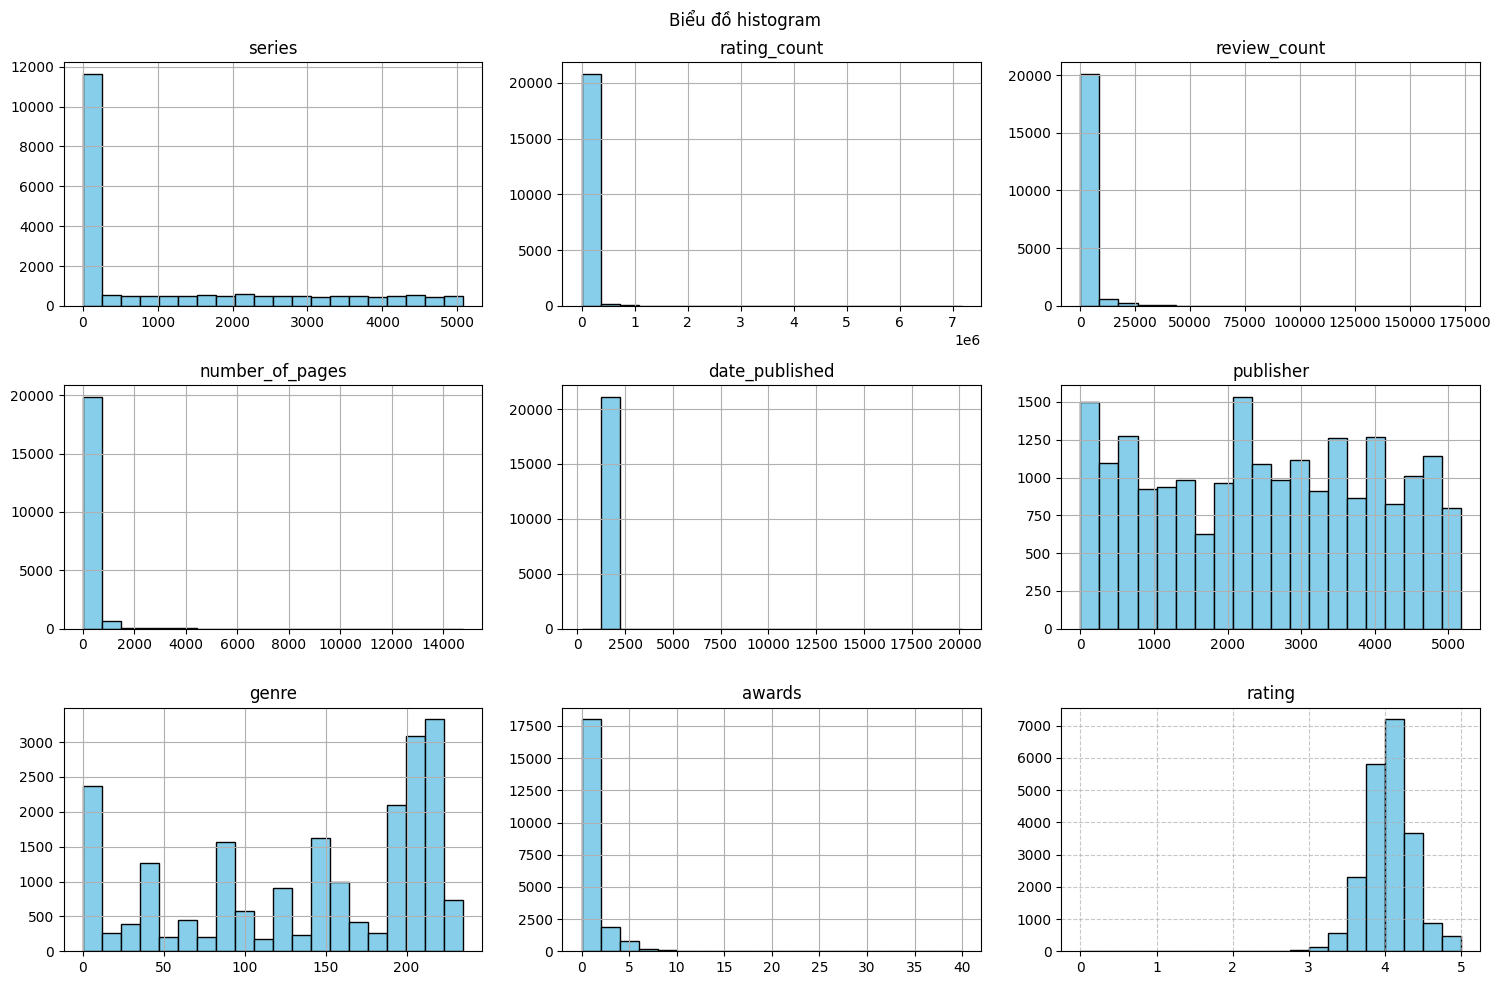

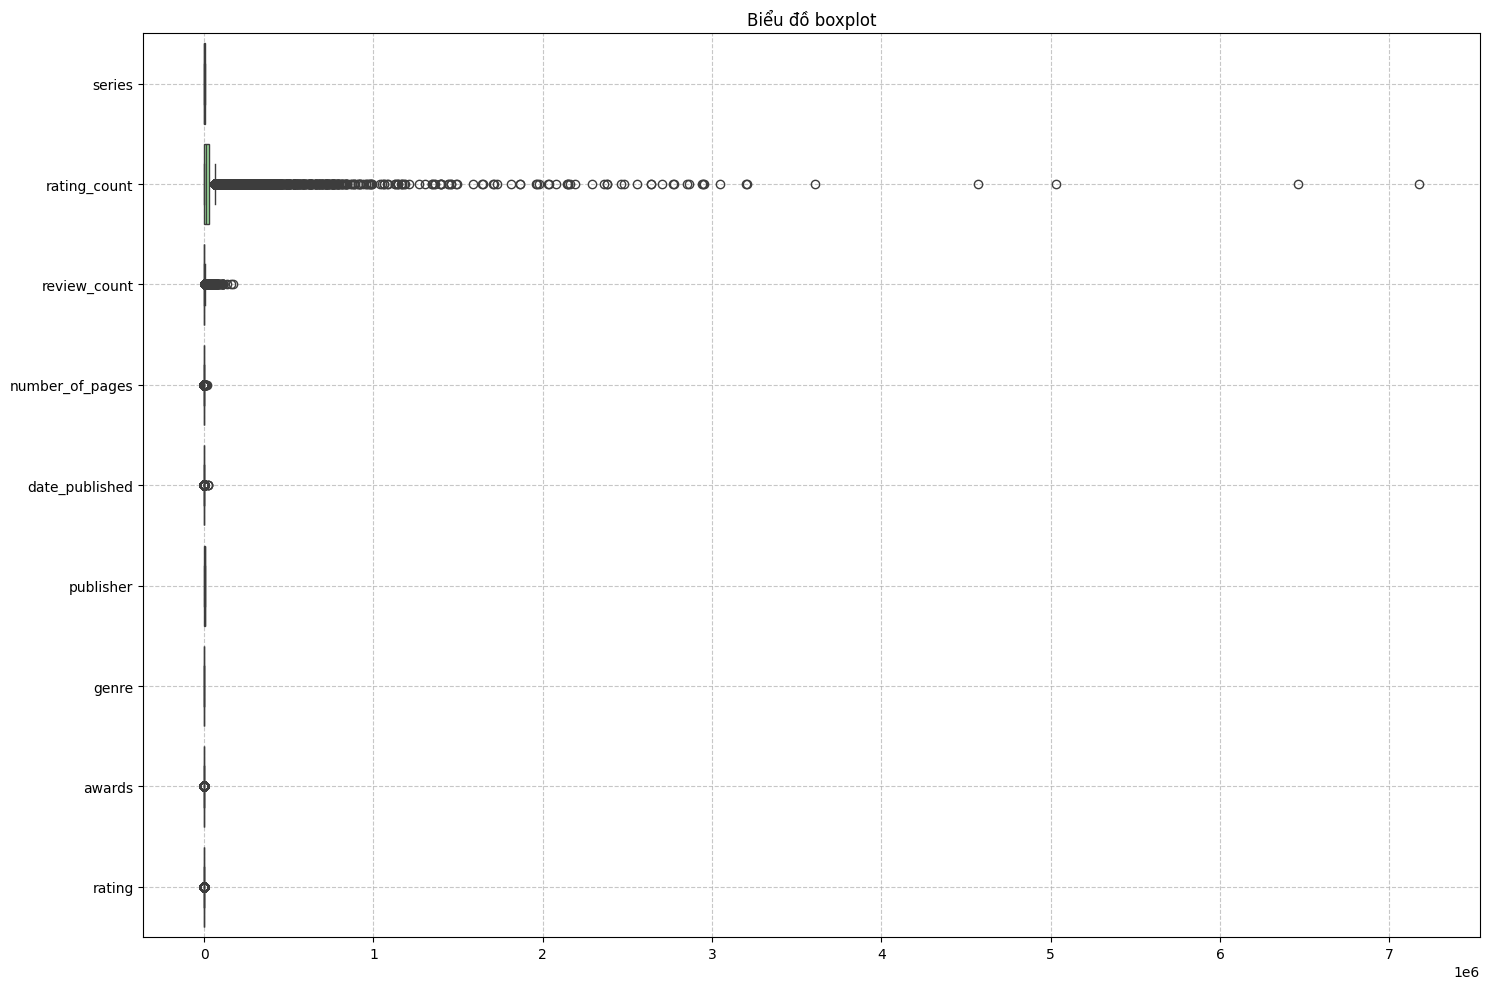

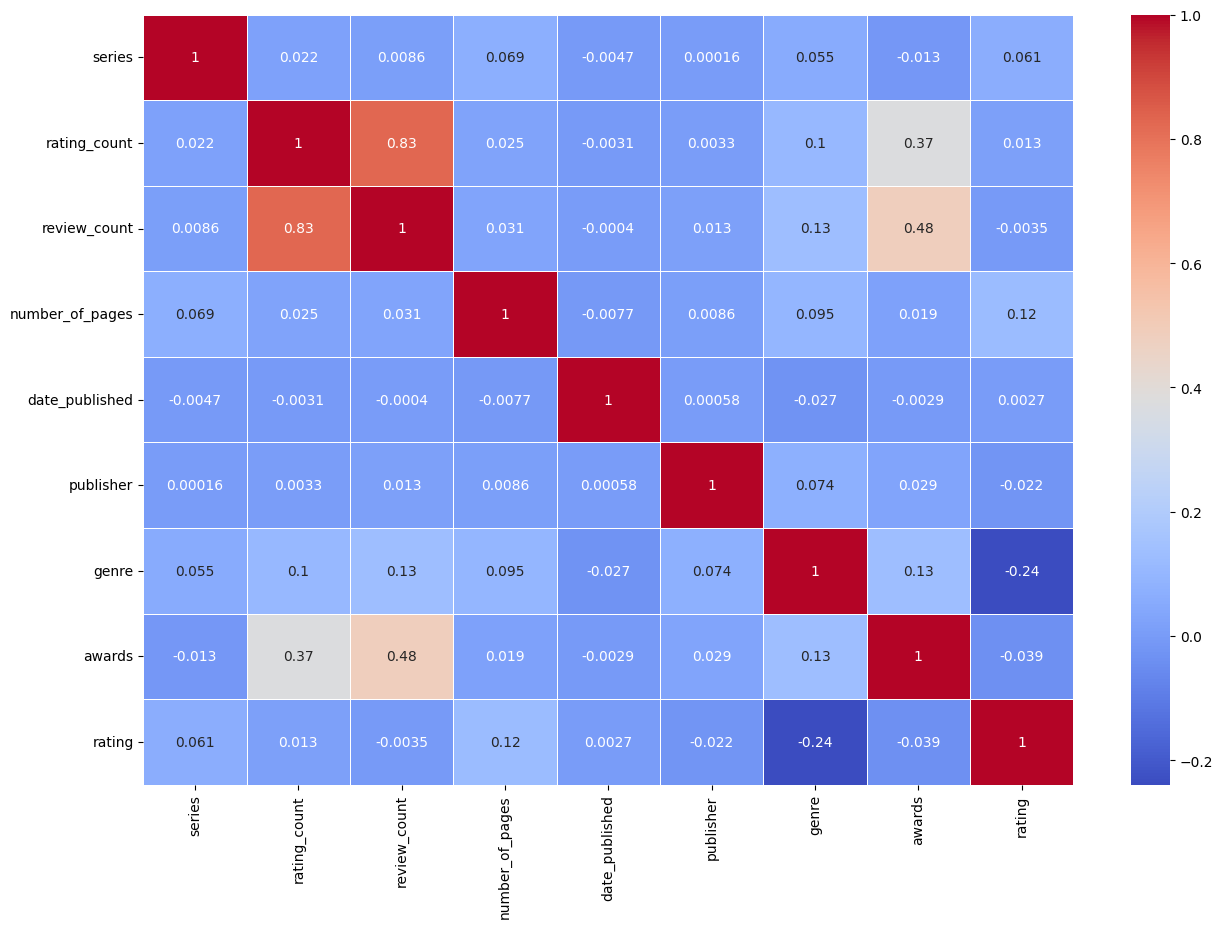

In [4]:
import pandas as pd
import re
import pickle
import warnings

from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = pd.read_csv('/content/rating_book1.csv')

df_numeric = df.select_dtypes(include=['number'])

pd.set_option("display.float_format", "{:.2f}".format)

def bang_thong_ke(df):
    desc_stats = pd.DataFrame({
        'Count': df.count(),
        'Min': df.min(),
        'Max': df.max(),
        'Mean': df.mean(),
        'Median': df.median(),
        'Q1': df.quantile(0.25),
        'Q2': df.quantile(0.5),
        'Q3': df.quantile(0.75),
        'IQR': df.quantile(0.75) - df.quantile(0.25),
        'Var': df.var(),
        'Std': df.std()
    })

    data_complete = desc_stats.transpose()
    print("\nBảng phân tích thống kê:")
    print(data_complete)
    return data_complete

bang_thong_ke(df_numeric)

df_count = df.count()
print(df_count)

print('Gia tri khuyet thieu:')
print(df.isna().sum())

print('Ty le khuyet thieu')
print((df.isna().sum()/df.shape[0]) * 100)

duplicates = df.duplicated()
num_duplicates = duplicates.sum()
print(f'Gia tri trung lap la: {num_duplicates}')

def formatTextSeries(text):
  if text != text: # Check nan-value
    return text
  return text.strip('()').split('#')[0].strip()

def formatSeries(df):
  df_copy = df.copy()
  df_copy['series'] = df_copy['series'].apply(formatTextSeries)
  return df_copy

df = formatSeries(df)
print(df['series'][4])

print(df['date_published'] .head(5))

def formatTextDate(text):
    if text != text: # Check nan-value
        return text
    temp = re.findall(r"[\w']+", text)[-1]
    if temp.isnumeric():
        return float(temp)
    return float('nan')

def formatDatePublished(df):
  df_copy = df.copy()
  df_copy['date_published'] = df_copy['date_published'].apply(formatTextDate)
  df_copy['date_published'] = df_copy['date_published'].astype(float)
  return df_copy

df = formatDatePublished(df)

df = df[df['date_published'] > 100]

def formatTextGenre(text):
  if text != text:
    return text
  return re.findall(r"[a-zA-Z- ]+", text)[0]

def formatGenre(df):
  df_copy = df.copy()
  df_copy['genre_and_votes'] = df_copy['genre_and_votes'].apply(formatTextGenre)
  df_copy.rename(columns={'genre_and_votes':'genre'}, inplace=True)
  return df_copy

df = formatGenre(df)


def formatTextAward(text):
  if text != text:
    return 0
  return len(text.split(','))


def formatAward(df):
  df_copy = df.copy()
  df_copy['awards'] = df_copy['awards'].apply(formatTextAward)
  return df_copy

df = formatAward(df)

def save_map(map, map_name):
  with open(map_name + '.pkl', 'wb') as f:
    pickle.dump(map, f, pickle.HIGHEST_PROTOCOL)


def load_map(map_name):
  with open(map_name + '.pkl', 'rb') as f:
    return pickle.load(f)


def createMappingTable(df, column, text_digit_vals):
  df_copy = df.copy()
  text_digit_vals_column = {}
  def convertToInt(text):
    if text != text or text == '' or text == 0:
      return 0
    return int(text_digit_vals_column[text])
  column_contents = df_copy[column].values.tolist()
  unique_elements = set(column_contents)
  x = 1
  for unique in unique_elements:
    if unique not in text_digit_vals_column and unique == unique and unique != 0:
      text_digit_vals_column[unique] = x
      x += 1
  text_digit_vals[column] = text_digit_vals_column
  df_copy[column] = list(map(convertToInt, df_copy[column]))
  return df_copy


def mapData(df, column, text_digit_vals):
  df_copy = df.copy()
  text_digit_vals_column = text_digit_vals[column]
  def convertToInt(text):
    if text != text or text == '' or text == 0:
      return 0
    return int(text_digit_vals_column[text])
  column_contents = df_copy[column].values.tolist()
  unique_elements = set(column_contents)
  #x = len(text_digit_vals_column)
  for unique in unique_elements:
    if unique not in text_digit_vals_column and unique == unique and unique != 0:
      text_digit_vals_column[unique] = 0
      #x += 1
  df_copy[column] = list(map(convertToInt, df_copy[column]))
  return df_copy

text_digit_vals = {}
df = createMappingTable(df,'series', text_digit_vals)
df = createMappingTable(df,'publisher', text_digit_vals)
df = createMappingTable(df,'genre', text_digit_vals)

save_map(text_digit_vals,'map')

df.drop(['link', 'author_link', 'settings', 'title', 'original_title', 'isbn', 'isbn13','author', 'characters','id','Unnamed: 0'], axis=1, inplace=True)

df_num = df.select_dtypes(['number'])

# Phân tích mô tả
def bang_thong_ke(df):
    desc_stats = pd.DataFrame({
        'Count': df.count(),
        'Min': df.min(),
        'Max': df.max(),
        'Mean': df.mean(),
        'Median': df.median(),
        'Q1': df.quantile(0.25),
        'Q2': df.quantile(0.5),
        'Q3': df.quantile(0.75),
        'IQR': df.quantile(0.75) - df.quantile(0.25),
        'Var': df.var(),
        'Std': df.std()
    })

    data_complete = desc_stats.transpose()
    print("\nBảng phân tích thống kê:")
    print(data_complete)
    return data_complete

# Áp dụng phân tích thống kê cho dữ liệu số
statistical_summary = bang_thong_ke(df_numeric)

df.hist(bins=20, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle('Biểu đồ histogram')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.figure(figsize=(15, 10))
sns.boxplot(data=df, orient="h", color='lightgreen')
plt.title('Biểu đồ boxplot')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

correlation_matrix = df_num.corr()
quality_corr = correlation_matrix['rating'].sort_values(ascending=False)
print('Muc do tuong quan')
print(quality_corr)

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

most_feature = quality_corr.index[1]
print(f"{most_feature} : {quality_corr[most_feature]}")

df_drop = df_num.dropna()
X = df_drop.drop('rating', axis=1)
y = df_drop['rating'].values

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

plt.figure(figsize=(8 ,6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Giá trị thực tế')
plt.ylabel('Giá trị dự đoán')
plt.title('Biểu đồ phân tán: Giá trị thực vs Dự đoán')
plt.show()

# So sánh các mô hình hồi quy cho từng biến
for column in X.columns:
    model = LinearRegression()
    X_col = X[[column]]
    X_train, X_test, y_train, y_test = train_test_split(X_col, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'Biến: {column}')
    print(f'MAE: {mae}, MSE: {mse}, R-squared: {r2}\n')

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
    plt.xlabel('Giá trị thực tế')
    plt.ylabel('Giá trị dự đoán')
    plt.title(f'Biểu đồ phân tán: {column} vs Giá trị dự đoán')
    plt.show()
#
# Khởi tạo từ điển để lưu kết quả
results = {
    'Biến': [],
    'MAE': [],
    'MSE': [],
    'R-squared': []
}

# Lặp qua từng cột (biến) và tính toán các chỉ số hồi quy
for column in X.columns:
    results['Biến'].append(column)

    model = LinearRegression()
    X_col = X[[column]]
    X_train, X_test, y_train, y_test = train_test_split(X_col, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results['MAE'].append(mae)
    results['MSE'].append(mse)
    results['R-squared'].append(r2)

# Chuyển kết quả thành DataFrame
results_df = pd.DataFrame(results)
print(results_df.to_string())

# Biểu đồ cột cho MAE
plt.figure(figsize=(14, 6))
sns.barplot(x='Biến', y='MAE', data=results_df, palette='viridis')
plt.title('So sánh MAE giữa các biến')
plt.xticks(rotation=90)
plt.show()

# Biểu đồ cột cho MSE
plt.figure(figsize=(14, 6))
sns.barplot(x='Biến', y='MSE', data=results_df, palette='viridis')
plt.title('So sánh MSE giữa các biến')
plt.xticks(rotation=90)
plt.show()

# Biểu đồ cột cho R-squared
plt.figure(figsize=(14, 6))
sns.barplot(x='Biến', y='R-squared', data=results_df, palette='viridis')
plt.title('So sánh R-squared giữa các biến')
plt.xticks(rotation=90)
plt.show()

import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

# Danh sách lưu kết quả
results_comparison = {
    'Model': [],
    'MAE': [],
    'MSE': [],
    'R-squared': []
}


# Hàm để đánh giá mô hình
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results_comparison['Model'].append(model_name)
    results_comparison['MAE'].append(mae)
    results_comparison['MSE'].append(mse)
    results_comparison['R-squared'].append(r2)


# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression
model_lr = LinearRegression()
evaluate_model(model_lr, X_train, X_test, y_train, y_test, 'Linear Regression')

# Support Vector Regression
reg_SVR = make_pipeline(StandardScaler(), SVR(C=0.5, gamma=0.1))
evaluate_model(reg_SVR, X_train, X_test, y_train, y_test, 'SVR')

# MLP Regression
reg_MLPR = make_pipeline(StandardScaler(), MLPRegressor(random_state=1, max_iter=500))
evaluate_model(reg_MLPR, X_train, X_test, y_train, y_test, 'MLP Regression')

# Chuyển kết quả thành DataFrame
results_comparison_df = pd.DataFrame(results_comparison)

# In kết quả
print(results_comparison_df)

# Vẽ biểu đồ cột cho các chỉ số
metrics = ['MAE', 'MSE', 'R-squared']

for metric in metrics:
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Model', y=metric, data=results_comparison_df, palette='viridis')
    plt.title(f'So sánh {metric} giữa các mô hình')
    plt.show()


import time
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Danh sách lưu kết quả
results_comparison = {
    'Model': [],
    'MAE': [],
    'MSE': [],
    'R-squared': [],
    'Training Time (s)': [],
    'Prediction Time (s)': []
}

Hàm để đánh giá mô hình
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Đo thời gian huấn luyện
    start_train = time.time()
    model.fit(X_train, y_train)
    end_train = time.time()
    training_time = end_train - start_train

    # Đo thời gian dự đoán
    start_predict = time.time()
    y_pred = model.predict(X_test)
    end_predict = time.time()
    prediction_time = end_predict - start_predict

    # Tính các chỉ số hiệu suất
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Ghi kết quả vào danh sách
    results_comparison['Model'].append(model_name)
    results_comparison['MAE'].append(mae)
    results_comparison['MSE'].append(mse)
    results_comparison['R-squared'].append(r2)
    results_comparison['Training Time (s)'].append(training_time)
    results_comparison['Prediction Time (s)'].append(prediction_time)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression
model_lr = LinearRegression()
evaluate_model(model_lr, X_train, X_test, y_train, y_test, 'Linear Regression')

# Support Vector Regression
reg_SVR = make_pipeline(StandardScaler(), SVR(C=0.5, gamma=0.1))
evaluate_model(reg_SVR, X_train, X_test, y_train, y_test, 'SVR')

# MLP Regression
reg_MLPR = make_pipeline(StandardScaler(), MLPRegressor(random_state=1, max_iter=500))
evaluate_model(reg_MLPR, X_train, X_test, y_train, y_test, 'MLP Regression')

# Chuyển kết quả thành DataFrame
results_comparison_df = pd.DataFrame(results_comparison)

# In kết quả
print(results_comparison_df.to_string())

# Vẽ biểu đồ cột cho các chỉ số hiệu suất
metrics = ['MAE', 'MSE', 'R-squared']

for metric in metrics:
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Model', y=metric, data=results_comparison_df, palette='viridis')
    plt.title(f'So sánh {metric} giữa các mô hình')
    plt.show()

# Vẽ biểu đồ thời gian
time_metrics = ['Training Time (s)', 'Prediction Time (s)']

for time_metric in time_metrics:
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Model', y=time_metric, data=results_comparison_df, palette='coolwarm')
    plt.title(f'So sánh {time_metric} giữa các mô hình')
    plt.show()


import psutil
import time
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Giả định dữ liệu đầu vào đã được xử lý
df_drop = df_num.dropna()
X = df_drop.drop('rating', axis=1)
y = df_drop['rating'].values

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Chia dữ liệu train-test ban đầu với 80% train và 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

# Các tỷ lệ train từ 25% đến 100% của tập train ban đầu
train_sizes = [0.25, 0.50, 0.75, 1.00]

# Hàm đo tài nguyên RAM và CPU
def measure_resources():
    cpu_percent = psutil.cpu_percent(interval=1)  # Đo CPU
    ram_percent = psutil.virtual_memory().percent  # Đo RAM
    return cpu_percent, ram_percent

# Hàm huấn luyện và đánh giá mô hình
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    # Huấn luyện mô hình
    start_time_train = time.time()
    cpu_before_train, ram_before_train = measure_resources()
    model.fit(X_train, y_train)
    cpu_after_train, ram_after_train = measure_resources()
    training_time = time.time() - start_time_train

    # Dự báo
    start_time_predict = time.time()
    y_pred = model.predict(X_test)
    prediction_time = time.time() - start_time_predict

    # Tính các chỉ số đánh giá
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Đảm bảo CPU và RAM luôn >= 0
    cpu_usage_train = max(0, cpu_after_train - cpu_before_train)
    ram_usage_train = max(0, ram_after_train - ram_before_train)

    return cpu_usage_train, ram_usage_train, training_time, prediction_time, mae, mse, r2

# Khởi tạo các mô hình
models = {
    "Linear Regression": LinearRegression(),
    "SVR": SVR(),
    "MLP Regression": MLPRegressor(max_iter=2000)
}

# Tạo một dataframe để lưu kết quả
results = []

# Tiến hành đo tài nguyên cho các mô hình với từng kích thước tập train
for train_size in train_sizes:
    # Lấy tập train theo tỷ lệ cụ thể
    current_X_train = X_train_full[:int(len(X_train_full) * train_size)]
    current_y_train = y_train_full[:int(len(y_train_full) * train_size)]

    for model_name, model in models.items():
        # Huấn luyện và đánh giá mô hình
        cpu_usage_train, ram_usage_train, training_time, prediction_time, mae, mse, r2 = train_and_evaluate_model(
            model, current_X_train, current_y_train, X_test, y_test
        )

        # Lưu kết quả vào dataframe
        results.append({
            "Model": model_name,
            "Train Size": f"{int(train_size * 100)}%",
            "CPU Usage (%)": cpu_usage_train,
            "RAM Usage (%)": ram_usage_train,
            "Training Time (s)": training_time,
            "Prediction Time (s)": prediction_time,
            "MAE": mae,
            "MSE": mse,
            "R-squared": r2
        })

# Chuyển kết quả thành DataFrame để dễ dàng xem xét
df_results = pd.DataFrame(results)

# Hiển thị kết quả
print(df_results.to_string())



In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col
import pandas as pd

# Bước 1: Khởi tạo SparkSession với cấu hình bổ sung
spark = SparkSession.builder.appName("LinearRegressionPipeline").getOrCreate()

# Chuyển đổi dữ liệu từ Pandas DataFrame sang Spark DataFrame
X_train_spark = spark.createDataFrame(X_train)
X_test_spark = spark.createDataFrame(X_test)

# Chuyển y_train và y_test thành DataFrame Spark với cột 'target'
y_train_spark = spark.createDataFrame(pd.DataFrame(y_train, columns=['target']))
y_test_spark = spark.createDataFrame(pd.DataFrame(y_test, columns=['target']))

# Gộp X_train_spark và y_train_spark theo cột 'index'
train_data = X_train_spark.join(y_train_spark)
test_data = X_test_spark.join(y_test_spark)

# Bước 2: Tạo VectorAssembler để kết hợp các tính năng (features)
feature_cols = [col for col in train_data.columns if col != 'target']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Bước 3: Thêm StandardScaler để chuẩn hóa đặc trưng
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# Bước 4: Tạo mô hình hồi quy tuyến tính
lr = LinearRegression(featuresCol="scaled_features", labelCol="target")

# Bước 5: Tạo Pipeline
pipeline = Pipeline(stages=[assembler, scaler, lr])

# Bước 6: Huấn luyện mô hình
model = pipeline.fit(train_data)

# Bước 7: Dự đoán trên dữ liệu test
predictions = model.transform(test_data)

# Bước 8: Đánh giá mô hình
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="target", metricName="rmse")
rmse = evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse}")

# Dừng SparkSession khi xong
spark.stop()
